In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from gensim.models import word2vec
import spacy
import nltk

nlp = spacy.load("en_core_web_lg")

from warnings import filterwarnings

filterwarnings("ignore")

In [2]:
df = pd.read_csv("Data/cleaned_data.csv")

In [3]:
df.head()

,Head,Body,Tags,Text,Tags Count
0,brain segmentation to 3d model,my goal is to take a dataset of brain tumor s...,"['computer-vision', 'python']",brain segmentation to 3d model my goal is to ...,2
1,active learning regression with random forest,i have a dataset of about 8k points and i am ...,"['machine-learning', 'regression', 'uncertaint...",active learning regression with random forest ...,5
2,comparing reinforcement learning models,i am currently completing my thesis on optimi...,"['reinforcement-learning', 'policy-gradients',...",comparing reinforcement learning models i am ...,4
3,why good model that performs great on holdout ...,i have this binary regression model that has ...,"['deep-learning', 'deep-neural-networks', 'pre...",why good model that performs great on holdout ...,5
4,what are reservoir computers used for today,reservoir computers were very popular in the ...,"['machine-learning', 'recurrent-neural-network...",what are reservoir computers used for today ...,3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48803 entries, 0 to 48802
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Head        48803 non-null  object
 1   Body        48803 non-null  object
 2   Tags        48803 non-null  object
 3   Text        48803 non-null  object
 4   Tags Count  48803 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


In [5]:
# Body Features Demographic Distribution

print("Max length of the body: ", df["Body"].str.len().max())
print("Min length of the body: ", df["Body"].str.len().min())
print("Mean length of the body: ", df["Body"].str.len().mean())
print("Median length of the body: ", df["Body"].str.len().median())

Max length of the body:  26349
Min length of the body:  34
Mean length of the body:  919.8135155625679
Median length of the body:  663.0


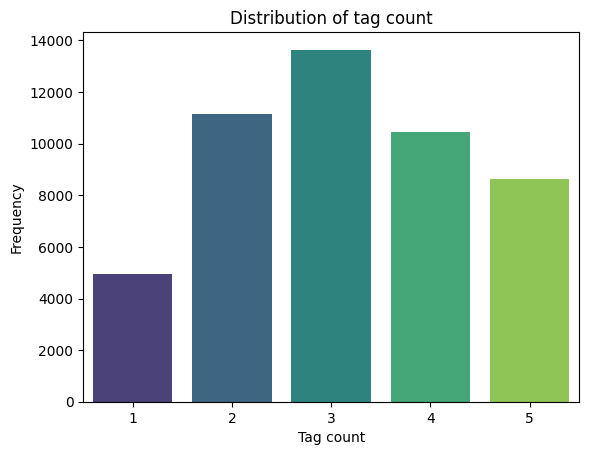

In [6]:
# plot distribution of tag count
sns.countplot(data=df, x="Tags Count", color="blue", palette="viridis")
plt.title("Distribution of tag count")
plt.ylabel("Frequency")
plt.xlabel("Tag count")
plt.show()

In [7]:
# vectorize tags
tag_vectorizer = TfidfVectorizer(tokenizer=lambda x: str(x).strip('[]').split())
tag_mat = tag_vectorizer.fit_transform(df["Tags"])

In [8]:
# get names of tags
tag_names = tag_vectorizer.get_feature_names_out()
type(tag_names), len(tag_names)

(numpy.ndarray, 4365)

In [9]:
tag_names[:20]

array(["'.net'", "'1d-convolution'", "'1d-convolution',",
       "'2d-convolution'", "'2d-convolution',", "'2sls'", "'2sls',",
       "'3d-convolution'", "'3d-convolution',", "'3d-reconstruction'",
       "'3d-reconstruction',", "'5-star-scheme'", "'5-star-scheme',",
       "'8-puzzle-problem'", "'8-puzzle-problem',", "'8-queens-problem'",
       "'a-star'", "'a-star',", "'a3c'", "'ab-test'"], dtype=object)

In [10]:
tag_freq = tag_mat.sum(axis=0)

In [11]:
# store tag names and frequency as a pandas series
tag_freq_ser = pd.Series(tag_freq.A1, index=tag_names)
tag_freq_ser.sort_values(ascending=False, inplace=True)
tag_freq_ser.head(10)

'machine-learning',          2112.786486
'r',                         1278.469959
'regression',                1165.600309
'deep-learning',             1045.606709
'neural-networks',            978.179973
'python',                     857.010483
'data-request',               825.379650
'classification',             751.126133
'reinforcement-learning',     700.970109
'time-series',                676.360431
dtype: float64

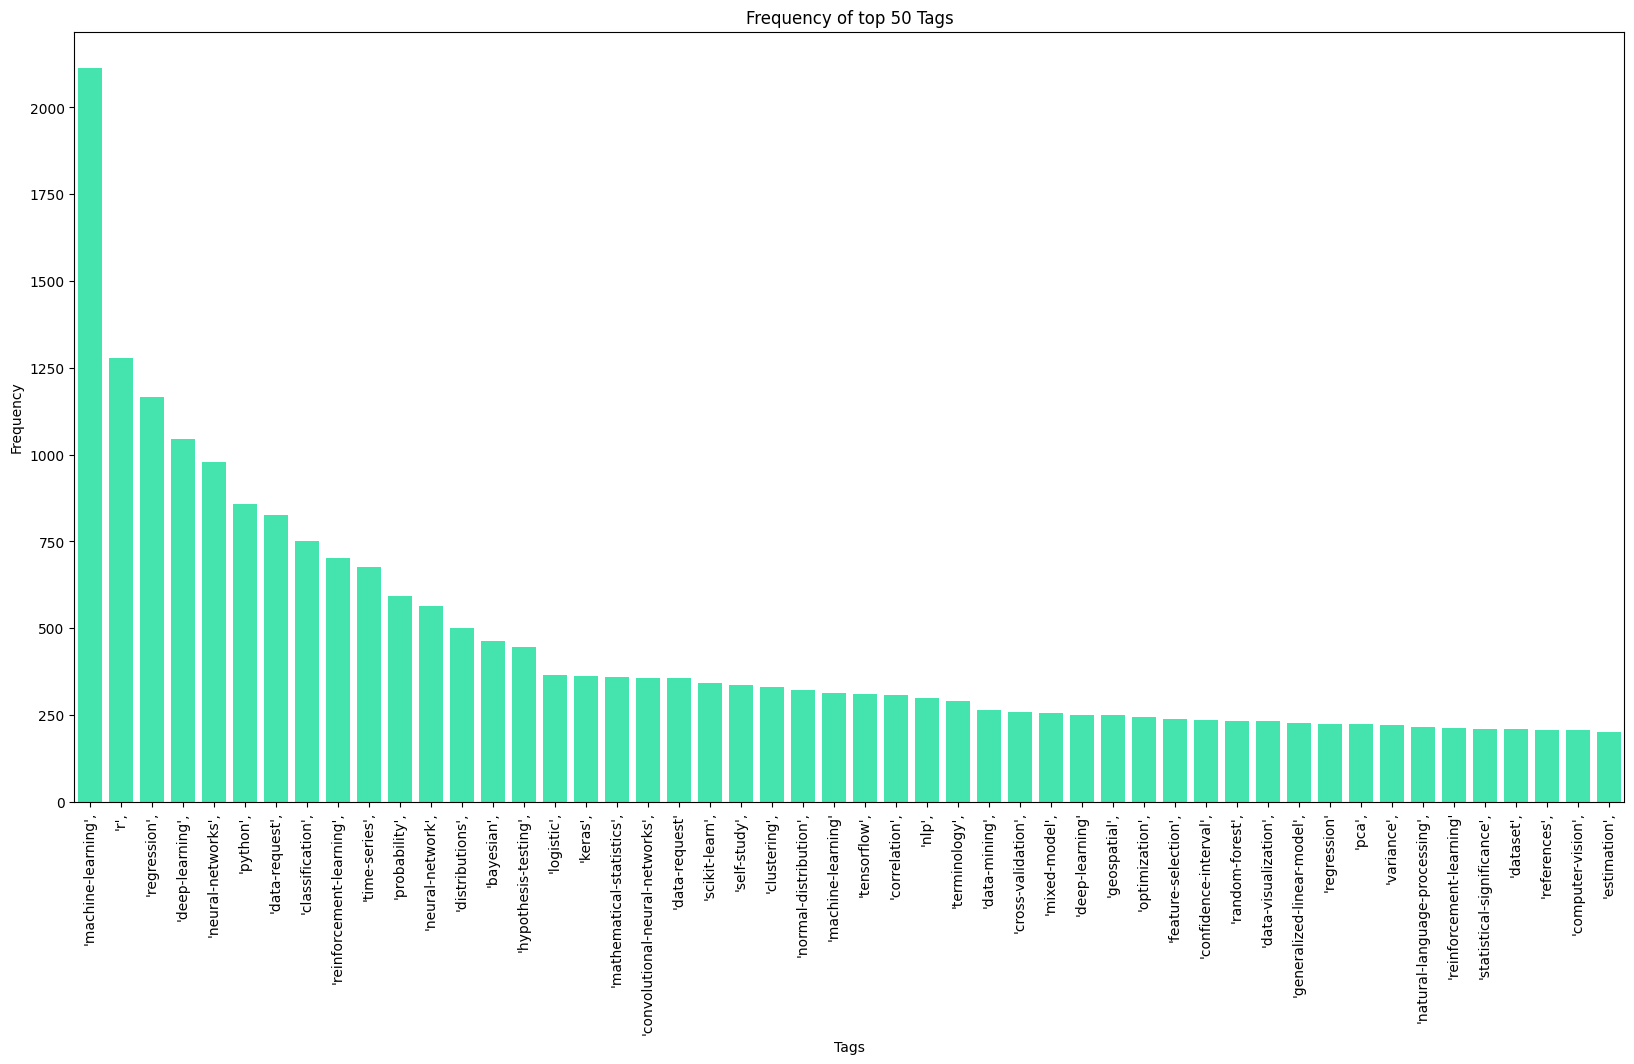

In [12]:
# Frequency top 50 tags
fig = plt.figure(figsize=[20, 10])
sns.barplot(
    x=tag_freq_ser.iloc[:50].index,
    y=tag_freq_ser.iloc[:50].values,
    color=sns.xkcd_rgb["greenish cyan"],
)
plt.title("Frequency of top 50 Tags")
plt.xlabel("Tags")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

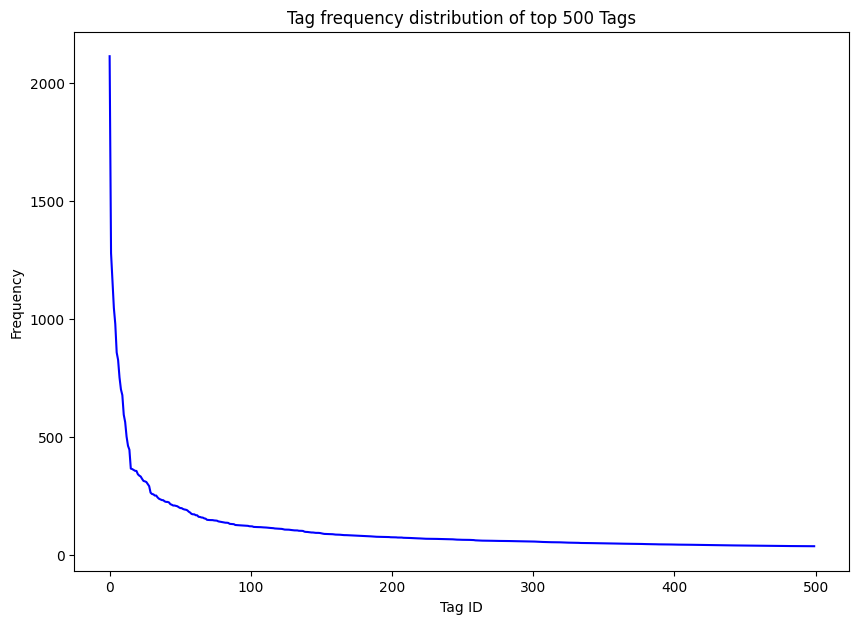

In [13]:
# plot distribution of tag frequency (top 500)
fig = plt.figure(figsize=[10, 7])
plt.plot(tag_freq_ser.iloc[:500].values, c="blue")
plt.title("Tag frequency distribution of top 500 Tags")
plt.ylabel("Frequency")
plt.xlabel("Tag ID")
plt.show()

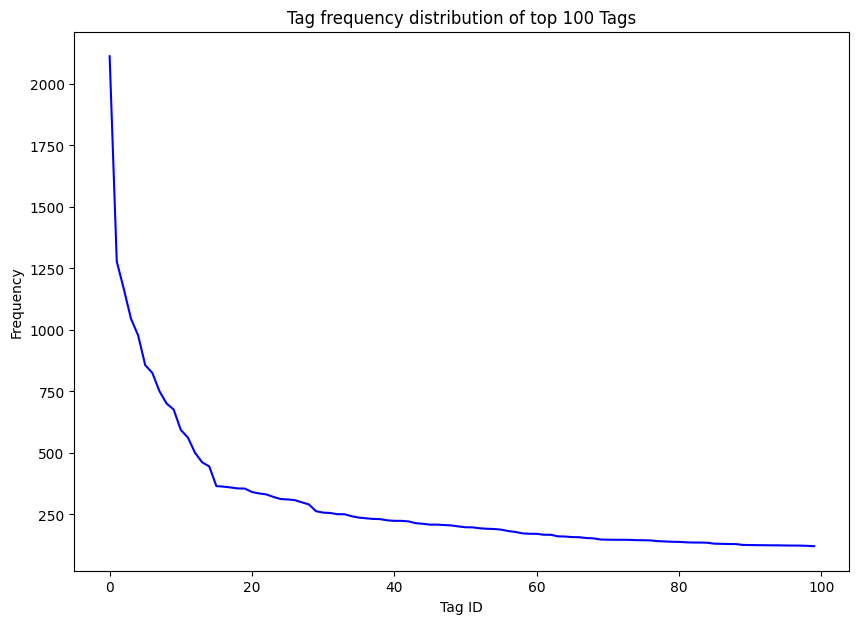

In [14]:
# plot distribution of tag frequency (top 100)
fig = plt.figure(figsize=[10, 7])
plt.plot(tag_freq_ser.iloc[:100].values, c="blue")
plt.title("Tag frequency distribution of top 100 Tags")
plt.ylabel("Frequency")
plt.xlabel("Tag ID")
plt.show()

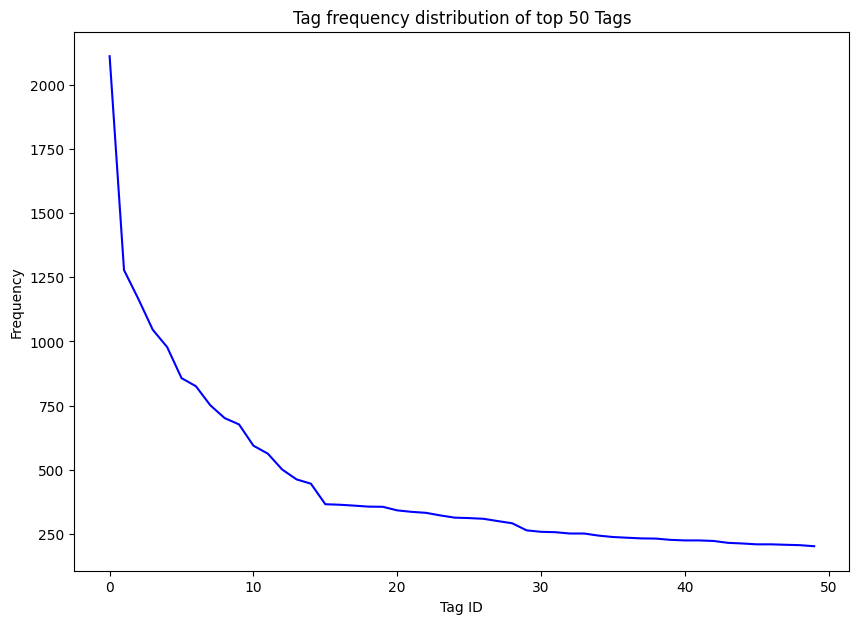

In [15]:
# plot distribution of tag frequency (top 50)
fig = plt.figure(figsize=[10, 7])
plt.plot(tag_freq_ser.iloc[:50].values, c="blue")
plt.title("Tag frequency distribution of top 50 Tags")
plt.ylabel("Frequency")
plt.xlabel("Tag ID")
plt.show()

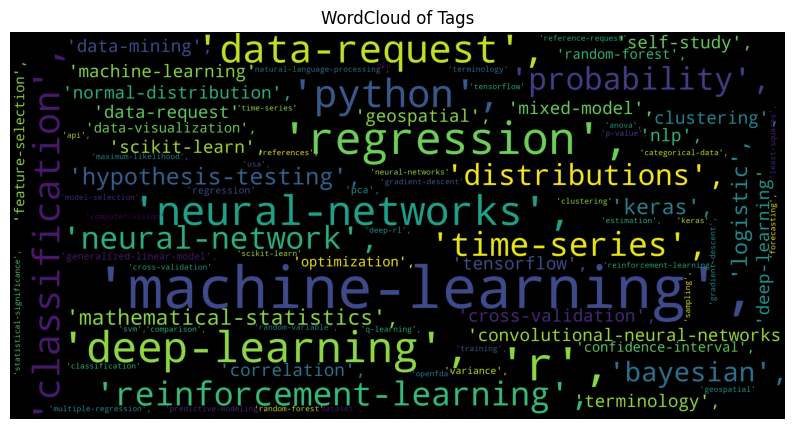

In [16]:
# plot word count for tags
wordcloud = WordCloud(
    background_color="black",
    max_words=200,
    scale=10,
).generate_from_frequencies(tag_freq_ser)
fig = plt.figure(figsize=[10, 10])
plt.title("WordCloud of Tags")
plt.axis("off")
plt.imshow(wordcloud)
plt.show()

In [17]:
# Create a list of stopwords
stopwords_nltk = nltk.corpus.stopwords.words("english")
stopwords_spacy = spacy.lang.en.stop_words.STOP_WORDS
stopwords = list(
    set(
        stopwords_nltk
        + list(stopwords_spacy)
        + list(STOPWORDS)
        + list("abdefghijklmnopqstuvwxyz")
    )
)
print(len(stopwords))

433


In [18]:
nlp = spacy.load("en_core_web_lg")


def clean_body(text):
    text = str(text).lower()
    text = " ".join([word for word in text.split() if word not in stopwords])
    text = nlp(text)
    text = " ".join([token.lemma_ for token in text])
    return text

df["Text_Cleaned"] = df["Text"].apply(clean_body)
# df['Head_Cleaned'] = df['Head'].apply(clean_body)
# df['Body_Cleaned'] = df['Body'].apply(clean_body)

In [19]:
# Create Word2Vec model from text column

list_of_sent = [sent.split() for sent in df["Text_Cleaned"].values]

w2v_model = word2vec.Word2Vec(list_of_sent, vector_size=100, window=5, workers=4)

w2v_model.wv.most_similar("detection")

[('anomaly', 0.7831667065620422),
 ('detector', 0.7682033777236938),
 ('detect', 0.7081571221351624),
 ('outli', 0.6996051669120789),
 ('yolo', 0.6753934025764465),
 ('segmentation', 0.6645662188529968),
 ('intrusion', 0.6639026999473572),
 ('novelty', 0.6576712727546692),
 ('tracking', 0.6438034772872925),
 ('fraud', 0.6335087418556213)]

In [21]:
df.to_csv('Data/cleaned_data_2.csv', index=False)